# HW3 k-means on MapReduce

## Setting config
1. import some lib
2. set the config

In [1]:
#initial
import math
import time
import pandas as pd
import matplotlib.pyplot as plt
from pyspark import SparkContext, SparkConf

sc.stop()
conf = SparkConf().setMaster("local").setAppName("KMeans")
conf = SparkConf().set("spark.default.parallelism", 1)
sc = SparkContext(conf = conf)

## Getting input data
1. use sc.textFile to get c1.txt, c2.txt and data.txt 
2. map them by mapper_init_parsing(x), which is parsing the line and split it by 空格
3. After parsing, we will get the RDDs which have key,value as [x0, x1, x2, ......, x57], for X is a 58-dimension vector

In [2]:
def mapper_init_parsing(x):
    y = x.split(' ')
    return y
#k=10
#for c1
c1 = sc.textFile("c1.txt").map(mapper_init_parsing)
#for c2
c2 = sc.textFile("c2.txt").map(mapper_init_parsing)
#for points
data = sc.textFile("data.txt").map(mapper_init_parsing)


## Giving C1, C2 and Data Index and then label them 
1. Since the initial input data doesn't give us the index for each centers, so we can use zipWithIndex() to that the C1, C2 and data RDDs such that their <key,value> will become <vector, index>
2. we use map(lambda x:("#",(x[1],x[0]))) to put index in front of vector, and then label them with '#' for next permutation

In [3]:
c1_new = c1
c2_new = c2
data_with_label = data.zipWithIndex().map(lambda x:("#",(x[1],x[0])))
C1_center_with_label = c1_new.zipWithIndex()
C2_center_with_label = c2_new.zipWithIndex()

## Map/Reduce Function define
1. mapper_cal_euclidaen_tmp(x):
    1. mapper_cal_euclidaen_tmp(x) is the map operation that calculate the Euclidean distance between each data point and each cluster center from the input RDD ( (point_index, point's 58_dimentions_values), (center_index, center's 58_dimentions_values))
    2. after finish calculation, output the <key,values> RDD as ( point_index, (center_index, point's 58_dimentions_values, Euclidean_distance) )
######  
2. reducer_find_min(x,y):
    1. reducer_find_min(x,y) is the reduce operation for finding the belonging cluster for each point by the most min distance
###### 
3. reducer_tmp_centroid(x,y):
    1. reducer_tmp_centroid(x,y) is  the reduce operation that help to sum up the vectors(i.e. point's 58_dimension_values) from all the points in same cluster, as the result the reduce key is the centroid point
    2. after computing sum up, we ouput the <key,values> RDD as (center, (numbers_of_points, result_of_sum_up))
###### 
4. cal_center_2(x):
    1. cal_center_2(x) is the map operation that divide the result_of_sum_up by numbers_of_points, and finally get the new cluster center
    2. So it will output the <key,values> RDD as (new_center_values, new_center_index), where new_center_index is same as previous center 
    3. I didn't ouput the index in front of values since after this map operation is at the end of iteration, and I will inverse them at the begging of next iteration
###### 

5. reducer_add(x,y):
    1. reducer_add(x,y) is the reduce operation that help us to calculate the cost of each iterations center after assign points.
    2. this operation will sum_up all the disctance of each point to its cluster center

In [4]:
def mapper_cal_euclidaen_tmp(x):
    #, ((pt_i,pt), (ce_i,ce))
    pt_index = x[1][0][0]
    pt = x[1][0][1]
    center_index = x[1][1][0]
    center = x[1][1][1]
    result = 0
    for i in range(58):
        result += (float(center[i])-float(pt[i]))**2
    result = math.sqrt(result)
    return pt_index,(center_index,pt,result)
def reducer_find_min(x,y):
    if x[2]<y[2]:
        return x
    else:
        return y
def reducer_tmp_centroid(x,y):
    pts = x[0]+y[0]
    result = []
    for i in range(58):
        result.append(float(x[1][i]) + float(y[1][i]))
    return pts,result
def cal_center_2(x):
    N = x[1][0]
    result = []
    for i in range(58):
        result.append(float(x[1][1][i])/float(N)) 
    return result,x[0]
def reducer_add(x,y):
    return x+y

## Iteration of Euclidean  
###### 約5分鐘執行時間
### take C1 for explanation: 
##### first, we give the C1_rdd the index, and then label then with '#', which will ouput the RDD C1_center_with_label

##### Assign point to its cluster
    1. Join the C1_center_with_label and  data_center_with_label to get their all permutation 
    (In fact, we can just use cartesian() to acheive it that we don't need to label with '#' beforehand)
    2. map them by calling mapper_cal_euclidaen_tmp(x) to calculate their all Euclidean Distance
    3. reduce them by reducer_find_min(x,y) to find out each data_point's cluster
    4. output the RDD name C1_Euclidean_result_RDD_tmp which <key,values> is (center_index, (point's 58_dimentions_values, Euclidean_distance))
##### Recompute the cluster center
    1. by the final output from Assign point to its cluster, we first should use map to give each line a count 1, which help us later use the reducer_tmp_centroid to calculate the point numbers inside a cluster, and also add_up all the points values with same cluster
    2. after reducer_tmp_centroid, we call the map operation 'cal_center_2' to calculate the mean and gain the new cluster center for each previous cluster center.
##### Calculate the Cost For plotting and answering the persentage
    1. map the C1_Euclidean_result_RDD_tmp with its values**2, and then use rdd.sum() to calculate the cost. 
    2. store the recent iteration and cost result to a list as x,y for plotting graph.
    

In [5]:
#########for storing every cost preparing for plotting and reference for percentage##############
C1_pts_Euclidean_i = []
C1_pts_Euclidean_cost = []
C2_pts_Euclidean_i = []
C2_pts_Euclidean_cost = []
#################################################################################################

#tStart = time.time()
for i in range(20):
    #print("iteration: "+ str(i))
    
    #====================C1 Euclidean=====================================#
    ####################Assign pt to its center############################
    C1_center_with_label = C1_center_with_label.map(lambda x:("#",(x[1],x[0])))
    C1_Euclidean_result_RDD_tmp = data_with_label.join(C1_center_with_label).map(mapper_cal_euclidaen_tmp).reduceByKey(reducer_find_min).map(lambda x:x[1])
    C1_centroid_cluster_Euclidean = C1_Euclidean_result_RDD_tmp.map(lambda x:(x[0],(1,x[1]))).reduceByKey(reducer_tmp_centroid).sortByKey(lambda x:x[0]).map(cal_center_2)
    ####################Recompute new center###############################
    C1_center_with_label = C1_centroid_cluster_Euclidean
    ####################Calculte cost######################################
    C1_Cost_RDD = C1_Euclidean_result_RDD_tmp.map(lambda x:(x[2]**2)).sum()
    #=====================================================================#
    
    #====================C2 Euclidean=====================================#
    C2_center_with_label = C2_center_with_label.map(lambda x:("#",(x[1],x[0])))
    C2_Euclidean_result_RDD_tmp = data_with_label.join(C2_center_with_label).map(mapper_cal_euclidaen_tmp).reduceByKey(reducer_find_min).map(lambda x:x[1])
    C2_centroid_cluster_Euclidean = C2_Euclidean_result_RDD_tmp.map(lambda x:(x[0],(1,x[1]))).reduceByKey(reducer_tmp_centroid).sortByKey(lambda x:x[0]).map(cal_center_2)
    
    C2_center_with_label = C2_centroid_cluster_Euclidean
    
    C2_Cost_RDD = C2_Euclidean_result_RDD_tmp.map(lambda x:(x[2]**2)).sum()
    #=====================================================================#
    
    #=====================for plotting====================================#
    C1_pts_Euclidean_cost.append(C1_Cost_RDD)
    C1_pts_Euclidean_i.append("Round "+str(i+1))
    C2_pts_Euclidean_cost.append(C2_Cost_RDD)
    C2_pts_Euclidean_i.append("Round "+str(i+1))
    #=====================================================================#
    
#tEnd = time.time()#計時結束
#print("It cost %f sec" % (tEnd - tStart))

## (a)-1  Plotting
1. from the result of C1_pts_Euclidean and C2_pts_Euclidean, which store every cost of each iteration, we can easily collect() them and finally use plot() to plot them on the graph
2. x-axis means iteration
3. y-axis means cost

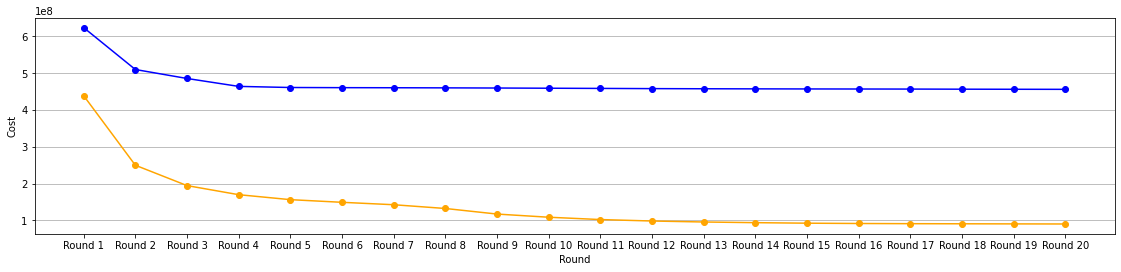

In [6]:
fig= plt.figure(figsize=(15,3))
axes= fig.add_axes([1,1,1,1])
plt.grid(axis='y')
plt.xlabel("Round") 
plt.ylabel("Cost") 
axes.plot(C1_pts_Euclidean_i,C1_pts_Euclidean_cost, color ='blue',marker = "o")
axes.plot(C2_pts_Euclidean_i,C2_pts_Euclidean_cost, color ='orange',marker = "o")
plt.show()

## (a)-2  Persentage

In [7]:
#c1
print(str((C1_pts_Euclidean_cost[0]-C1_pts_Euclidean_cost[19])/C1_pts_Euclidean_cost[0]*100)+"%")

26.885383292518295%


In [8]:
#c2
print(str((C2_pts_Euclidean_cost[0]-C2_pts_Euclidean_cost[19])/C2_pts_Euclidean_cost[0]*100)+"%")

79.43775029159899%


# For problem (b)

## Iteration of Manhattan
###### 約5分鐘執行時間
1. the processes is same as the Iteration of Euclidean
2. the only different between the Iteration of Manhattan and Iteration of Euclidean is that we only have to modify the function define

### Modify function
1. mapper_cal_manhattan(x) is similar as mapper_cal_Euclidean that we don't have to do the the squre(i.e. **2) and sqrt() operation

In [9]:
def mapper_cal_manhattan(x):
    #, ((pt_i,pt), (ce_i,ce))
    pt_index = x[1][0][0]
    pt = x[1][0][1]
    center_index = x[1][1][0]
    center = x[1][1][1]
    result = 0
    for i in range(58):
        result += abs((float(center[i])-float(pt[i])))
    result = result
    return pt_index,(center_index,pt,result)

In [10]:
#########for storing every cost preparing for plotting and reference for percentage##############
C1_pts_Manhattan_i = []
C1_pts_Manhattan_cost = []
C2_pts_Manhattan_i = []
C2_pts_Manhattan_cost = []
#################################################################################################

C1_center_with_label = c1_new.zipWithIndex()
C2_center_with_label = c2_new.zipWithIndex()
#tStart = time.time()
for i in range(20):
    #print("iteration: "+ str(i))
    #====================C1 Manhattan=====================================#
    C1_center_with_label = C1_center_with_label.map(lambda x:("#",(x[1],x[0])))
    C1_manhattan_result_RDD_tmp = data_with_label.join(C1_center_with_label).map(mapper_cal_manhattan).reduceByKey(reducer_find_min).map(lambda x:x[1])
    C1_centroid_cluster_manhattan = C1_manhattan_result_RDD_tmp.map(lambda x:(x[0],(1,x[1]))).reduceByKey(reducer_tmp_centroid).sortByKey(lambda x:x[0]).map(cal_center_2)
    
    C1_center_with_label = C1_centroid_cluster_manhattan
    
    C1_Cost_RDD = C1_manhattan_result_RDD_tmp.map(lambda x:(x[2])).sum()
    #=====================================================================#
    
    
    #====================C2 Manhattan=====================================#
    C2_center_with_label = C2_center_with_label.map(lambda x:("#",(x[1],x[0])))
    C2_manhattan_result_RDD_tmp = data_with_label.join(C2_center_with_label).map(mapper_cal_manhattan).reduceByKey(reducer_find_min).map(lambda x:x[1])
    C2_centroid_cluster_manhattan = C2_manhattan_result_RDD_tmp.map(lambda x:(x[0],(1,x[1]))).reduceByKey(reducer_tmp_centroid).sortByKey(lambda x:x[0]).map(cal_center_2)
    
    C2_center_with_label = C2_centroid_cluster_manhattan
    
    C2_Cost_RDD = C2_manhattan_result_RDD_tmp.map(lambda x:(x[2])).sum()
    #=====================================================================#
    
    #=====================for plotting====================================#
    C1_pts_Manhattan_i.append("Round "+str(i+1)) 
    C1_pts_Manhattan_cost.append(C1_Cost_RDD) 
    C2_pts_Manhattan_i.append("Round "+str(i+1)) 
    C2_pts_Manhattan_cost.append(C2_Cost_RDD) 
    #=====================================================================#
    
#tEnd = time.time()#計時結束
#print("It cost %f sec" % (tEnd - tStart))

## (b)-1  Plotting

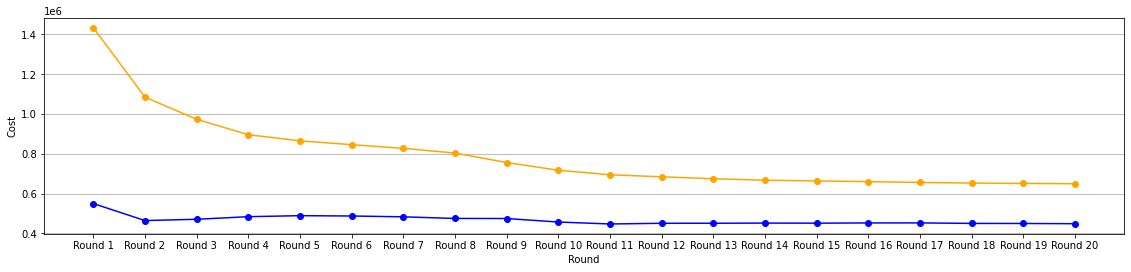

In [11]:
fig= plt.figure(figsize=(15,3))
axes= fig.add_axes([1,1,1,1])
plt.grid(axis='y')
plt.xlabel("Round") 
plt.ylabel("Cost") 
axes.plot(C1_pts_Manhattan_i,C1_pts_Manhattan_cost, color ='blue',marker = "o")
axes.plot(C2_pts_Manhattan_i,C2_pts_Manhattan_cost, color ='orange',marker = "o")
plt.show()

## (b)-2 Persentage

In [12]:
#c1
print(str((C1_pts_Manhattan_cost[0]-C1_pts_Manhattan_cost[19])/C1_pts_Manhattan_cost[0]*100)+"%")

18.393840107083186%


In [13]:
#c2
print(str((C2_pts_Manhattan_cost[0]-C2_pts_Manhattan_cost[19])/C2_pts_Manhattan_cost[0]*100)+"%")

54.68569434813374%


### Filled the Excel 
已將結果截圖至report
1. collect the data from C1(C2)_th20_center_Euclidean(Manhattan).
2. setting row name and columne name.
3. zip them as a dataframe and than call dataframe.to_excel() to output the excel respectly.

In [14]:
def cal_Euclidean_distance_for_each_center(x):
    pt1 = x[0][1]
    pt2 = x[1][1]
    result = 0
    for i in range(58):
        result += (float(pt1[i])-float(pt2[i]))**2
    result = math.sqrt(result)
    return (x[0][0],x[1][0]),result
C1_th20_center_Euclidean = C1_centroid_cluster_Euclidean.map(lambda x:(x[1],x[0]))
C1_filled_ans_Euclidean = C1_th20_center_Euclidean.cartesian(C1_th20_center_Euclidean).filter(lambda x:x[0][0]<=x[1][0]).map(cal_Euclidean_distance_for_each_center).sortBy(lambda x:x[0][0])
C1_filled_ans_Euclidean.collect()
#build dataframe before write into excel
col1 = []
col2 = [""]
col3 = ["",""]
col4 = ["","",""]
col5 = ["","","",""]
col6 = ["","","","",""]
col7 = ["","","","","",""]
col8 = ["","","","","","",""]
col9 = ["","","","","","","",""]
col10 = ["","","","","","","","",""]
all_col = [col1,col2,col3,col4,col5,col6,col7,col8,col9,col10]
col = ["1","2","3","4","5","6","7","8","9","10"]
for i in C1_filled_ans_Euclidean.collect():
    all_col[int(i[0][0])].append(format(i[1],'.3f'))
excel_c1_eu = pd.DataFrame(all_col,columns = col)
excel_c1_eu.index = col
excel_c1_eu.to_excel('C1_Euclidean.xlsx')

In [15]:
C2_th20_center_Euclidean = C2_centroid_cluster_Euclidean.map(lambda x:(x[1],x[0]))
C2_filled_ans_Euclidean = C2_th20_center_Euclidean.cartesian(C2_th20_center_Euclidean).filter(lambda x:x[0][0]<=x[1][0]).map(cal_Euclidean_distance_for_each_center).sortBy(lambda x:x[0][0])
C2_filled_ans_Euclidean.collect()
#build dataframe before write into excel
col1 = []
col2 = [""]
col3 = ["",""]
col4 = ["","",""]
col5 = ["","","",""]
col6 = ["","","","",""]
col7 = ["","","","","",""]
col8 = ["","","","","","",""]
col9 = ["","","","","","","",""]
col10 = ["","","","","","","","",""]
all_col = [col1,col2,col3,col4,col5,col6,col7,col8,col9,col10]
col = ["1","2","3","4","5","6","7","8","9","10"]
for i in C2_filled_ans_Euclidean.collect():
    all_col[int(i[0][0])].append(format(i[1],'.3f'))
excel_c2_eu = pd.DataFrame(all_col,columns = col)
excel_c2_eu.index = col
excel_c2_eu.to_excel('C2_Euclidean.xlsx')

In [16]:
def cal_Manhattan_distance_for_each_center(x):
    pt1 = x[0][1]
    pt2 = x[1][1]
    result = 0
    for i in range(58):
        result += abs((float(pt1[i])-float(pt2[i])))
    return (x[0][0],x[1][0]),result
C1_th20_center_manhattan = C1_centroid_cluster_manhattan.map(lambda x:(x[1],x[0]))
C1_filled_ans_manhattan = C1_th20_center_manhattan.cartesian(C1_th20_center_manhattan).filter(lambda x:x[0][0]<=x[1][0]).map(cal_Manhattan_distance_for_each_center).sortBy(lambda x:x[0][0])
C1_filled_ans_manhattan.collect()
#build dataframe before write into excel
col1 = []
col2 = [""]
col3 = ["",""]
col4 = ["","",""]
col5 = ["","","",""]
col6 = ["","","","",""]
col7 = ["","","","","",""]
col8 = ["","","","","","",""]
col9 = ["","","","","","","",""]
col10 = ["","","","","","","","",""]
all_col = [col1,col2,col3,col4,col5,col6,col7,col8,col9,col10]
col = ["1","2","3","4","5","6","7","8","9","10"]
for i in C1_filled_ans_manhattan.collect():
    all_col[int(i[0][0])].append(format(i[1],'.3f'))
excel_c1_ma = pd.DataFrame(all_col,columns = col)
excel_c1_ma.index = col
excel_c1_ma.to_excel('C1_Manhattan.xlsx')

In [18]:
C2_th20_center_manhattan = C2_centroid_cluster_manhattan.map(lambda x:(x[1],x[0]))
C2_filled_ans_manhattan = C2_th20_center_manhattan.cartesian(C2_th20_center_manhattan).filter(lambda x:x[0][0]<=x[1][0]).map(cal_Manhattan_distance_for_each_center).sortBy(lambda x:x[0][0])
C2_filled_ans_manhattan.collect()
col1 = []
col2 = [""]
col3 = ["",""]
col4 = ["","",""]
col5 = ["","","",""]
col6 = ["","","","",""]
col7 = ["","","","","",""]
col8 = ["","","","","","",""]
col9 = ["","","","","","","",""]
col10 = ["","","","","","","","",""]
all_col = [col1,col2,col3,col4,col5,col6,col7,col8,col9,col10]
col = ["1","2","3","4","5","6","7","8","9","10"]
for i in C2_filled_ans_manhattan.collect():
    all_col[int(i[0][0])].append(format(i[1],'.3f'))
excel_c2_ma = pd.DataFrame(all_col,columns = col)
excel_c2_ma.index = col
excel_c2_ma.to_excel('C2_Manhattan.xlsx')